In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vtk_rw import read_vtk
import lmfit

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
colors = sns.color_palette('cubehelix', 10)

Note that the calculation of chi-square and reduced chi-square assume that the returned residual function is scaled properly to the uncertainties in the data. For these statistics to be meaningful, the person writing the function to be minimized must scale them properly.

Swapping x and y?

step function convolved with gaussian: https://lmfit.github.io/lmfit-py/model.html, or different step functions plus linear trend

### Load data

In [4]:
hemi='rh'

mesh_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_%s_d.vtk'%hemi
sulc_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/surfs/lowres_%s_d_sulc.npy'%hemi
mask_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/masks/%s_fullmask.npy'%hemi
embed_file='/scr/ilz3/myelinconnect/all_data_on_simple_surf/embed/connectivity/%s_smooth_3_embed_10.npy'%hemi
t1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/smooth_3/avg_%s_profiles_smooth_3.npy'%hemi
r1_file = '/scr/ilz3/myelinconnect/all_data_on_simple_surf/t1/smooth_3/avg_%s_r1_smooth_3.npy'%hemi

In [5]:
v,f,d = read_vtk(mesh_file)
mask = np.load(mask_file)
embedding = np.load(embed_file)
t1_profiles = np.load(t1_file)
r1_profiles = np.load(r1_file)
sulc = np.load(sulc_file)

### Mask and average

In [6]:
t1_profiles[mask]=0
r1_profiles[mask]=0

In [7]:
t1_avg = np.mean(t1_profiles[:,3:8], axis=1)
t1_avg_supra = np.mean(t1_profiles[:,6:8], axis=1)
t1_avg_infra = np.mean(t1_profiles[:,3:5], axis=1)

r1_avg = np.mean(r1_profiles[:,3:8], axis=1)
r1_avg_supra = np.mean(r1_profiles[:,6:8], axis=1)
r1_avg_infra = np.mean(r1_profiles[:,3:5], axis=1)

In [8]:
scatter_t1avg = np.delete(t1_avg, mask)
scatter_t1avg_supra = np.delete(t1_avg_supra, mask)
scatter_t1avg_infra = np.delete(t1_avg_infra, mask)

scatter_r1avg = np.delete(r1_avg, mask)
scatter_r1avg_supra = np.delete(r1_avg_supra, mask)
scatter_r1avg_infra = np.delete(r1_avg_infra, mask)

scatter_embed_t1 = np.delete(embedding, mask, axis=0)
scatter_embed_r1 = np.delete(embedding, mask, axis=0)

t1_idx=np.where(scatter_t1avg<=1500)
scatter_t1avg = np.delete(scatter_t1avg, t1_idx)
scatter_t1avg_supra = np.delete(scatter_t1avg_supra, t1_idx)
scatter_t1avg_infra = np.delete(scatter_t1avg_infra, t1_idx)
scatter_embed_t1 = np.delete(scatter_embed_t1, t1_idx, axis=0)


r1_idx=np.where(scatter_r1avg>(1./1500))
scatter_r1avg = np.delete(scatter_r1avg, r1_idx)
scatter_r1avg_supra = np.delete(scatter_r1avg_supra, r1_idx)
scatter_r1avg_infra = np.delete(scatter_r1avg_infra, r1_idx)
scatter_embed_r1 = np.delete(scatter_embed_r1, r1_idx, axis=0)

### Plot 2D histogramms

In [9]:
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.3)

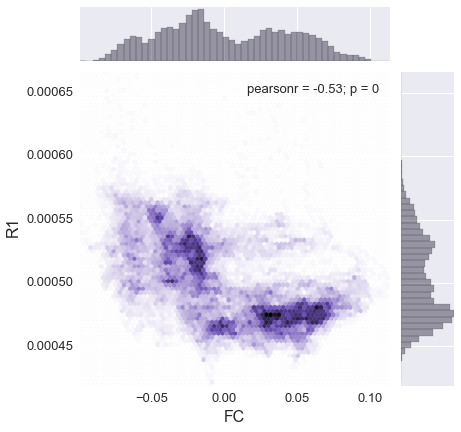

In [10]:
g = sns.jointplot(scatter_embed_r1[:,0], scatter_r1avg, kind="hex", size=6, color=colors[0])
g.set_axis_labels('FC', 'R1', fontsize=16)

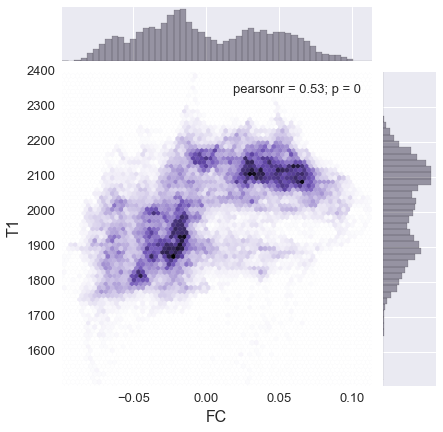

In [11]:
g = sns.jointplot(scatter_embed_t1[:,0], scatter_t1avg, kind="hex", size=6, color=colors[0])
g.set_axis_labels('FC', 'T1', fontsize=16)

### Normalize data to get sensible model comparison

Is this valid, given the data are not normally distributed? 

In [12]:
t1_norm = (scatter_t1avg - np.mean(scatter_t1avg)) / (np.std(scatter_t1avg))
r1_norm = (scatter_r1avg - np.mean(scatter_r1avg)) / (np.std(scatter_r1avg))
embed1_t1_norm = (scatter_embed_t1[:,0] - np.mean(scatter_embed_t1[:,0])) / (np.std(scatter_embed_t1[:,0]))
embed1_r1_norm = (scatter_embed_r1[:,0] - np.mean(scatter_embed_r1[:,0])) / (np.std(scatter_embed_r1[:,0]))

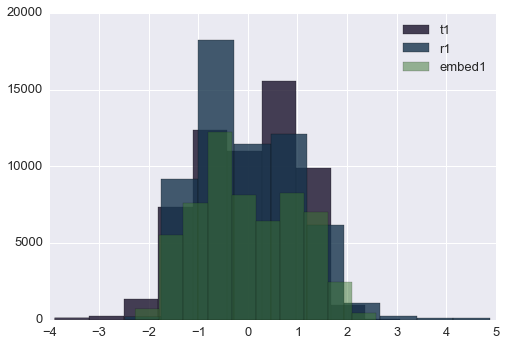

In [13]:
plt.hist(t1_norm, alpha=0.8, color=colors[0], label='t1');
plt.hist(r1_norm, alpha=0.8, color=colors[1], label='r1');
#plt.hist(embed1_t1_norm, alpha=0.7, color=colors[2], label='embed1_t1');
plt.hist(embed1_r1_norm, alpha=0.5, color=colors[3], label='embed1');
plt.legend()

### Model

In [14]:
def custom_plot(x, y, res, xlabel=None, ylabel=None, data_color=colors[1]):
    fig=plt.figure(figsize=(12,5))
    fig.add_subplot(121)
    plt.plot(x, y, alpha=0.1, marker='.', linestyle='None', color=data_color)
    plt.plot(x, res.best_fit, color='black', linestyle='None', marker='.', markersize=.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    fig.add_subplot(122)
    res.plot_residuals(data_kws={'alpha':0.1, 'color':'grey', 'marker':'.'}, fit_kws={'color':'k', 'linewidth':2})
    
def custom_report(res, label):
    print '##### %s #####'%label
    print res.fit_report()
    print 'BIC', res.bic
    print 'AIC', res.aic
    print ''

### Linear fit

##### T1 #####
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # function evals   = 5
    # data points      = 58921
    # variables        = 2
    chi-square         = 42125.002
    reduced chi-square = 0.715
[[Variables]]
    slope:       0.53390974 +/- 0        (0.00%) (init= 0.5339097)
    intercept:   4.8482e-16 +/- 0        (0.00%) (init= 4.848206e-16)
[[Correlations]] (unreported correlations are <  0.100)

BIC -19747.334311
AIC -19765.3022166

##### R1 #####
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # function evals   = 5
    # data points      = 58818
    # variables        = 2
    chi-square         = 42332.394
    reduced chi-square = 0.720
[[Variables]]
    slope:      -0.52941633 +/- 0        (0.00%) (init=-0.5294163)
    intercept:  -3.1580e-15 +/- 0        (0.00%) (init=-3.157983e-15)
[[Correlations]] (unreported correlations are <  0.100)

BIC -19321.0011153
AIC -19338.9655217



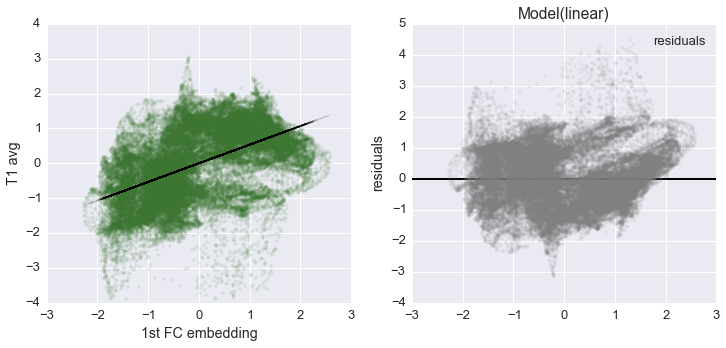

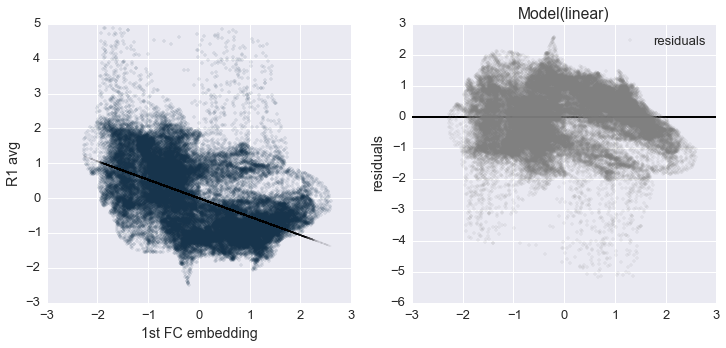

In [25]:
lin_model = lmfit.models.LinearModel()

lin_pars_t1 = lin_model.guess(t1_norm, x=embed1_t1_norm)
lin_out_t1 = lin_model.fit(t1_norm, lin_pars_t1, x=embed1_t1_norm)
lin_pars_r1 = lin_model.guess(r1_norm, x=embed1_r1_norm)
lin_out_r1 = lin_model.fit(r1_norm, lin_pars_r1, x=embed1_r1_norm)

custom_report(lin_out_t1, 'T1')
custom_report(lin_out_r1, 'R1')

custom_plot(embed1_t1_norm, t1_norm, lin_out_t1, xlabel='1st FC embedding', ylabel='T1 avg', data_color=colors[3])
custom_plot(embed1_r1_norm, r1_norm, lin_out_r1, xlabel='1st FC embedding', ylabel='R1 avg', data_color=colors[1])

### Quadratic fit

##### T1 #####
[[Model]]
    Model(parabolic)
[[Fit Statistics]]
    # function evals   = 6
    # data points      = 58921
    # variables        = 3
    chi-square         = 40405.342
    reduced chi-square = 0.686
[[Variables]]
    a:  -0.16914508 +/- 0.003377 (2.00%) (init=-0.1691451)
    b:   0.56125768 +/- 0.003455 (0.62%) (init= 0.5612577)
    c:   0.16914508 +/- 0.004800 (2.84%) (init= 0.1691451)
[[Correlations]] (unreported correlations are <  0.100)
    C(a, c)                      = -0.704 
    C(a, b)                      = -0.158 
    C(b, c)                      =  0.111 

BIC -22191.1448012
AIC -22218.0966597

##### R1 #####
[[Model]]
    Model(parabolic)
[[Fit Statistics]]
    # function evals   = 6
    # data points      = 58818
    # variables        = 3
    chi-square         = 40689.162
    reduced chi-square = 0.692
[[Variables]]
    a:   0.16554452 +/- 0.003396 (2.05%) (init= 0.1655445)
    b:  -0.55643395 +/- 0.003474 (0.62%) (init=-0.556434)
    c:  -0.16554451 +

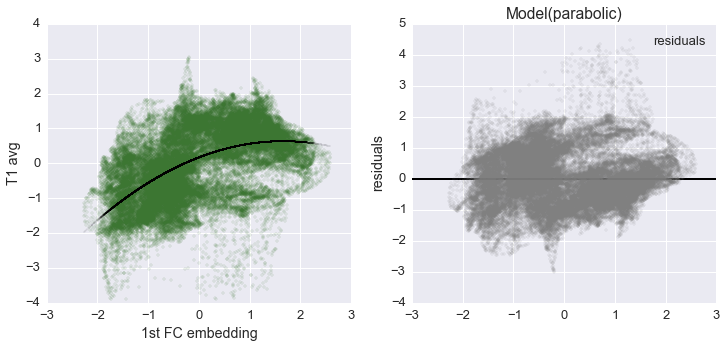

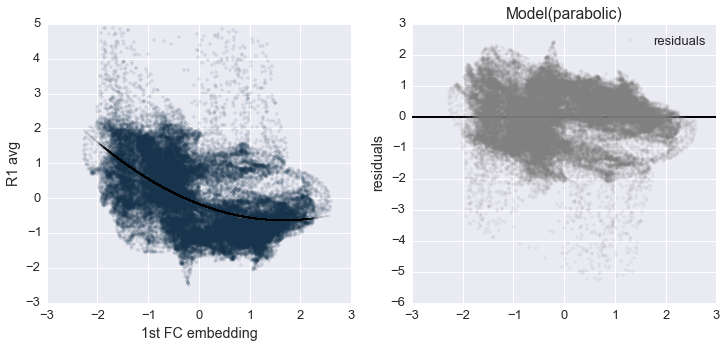

In [26]:
quad_model = lmfit.models.QuadraticModel()

quad_pars_t1 = quad_model.guess(t1_norm, x=embed1_t1_norm)
quad_out_t1 = quad_model.fit(t1_norm, quad_pars_t1, x=embed1_t1_norm)
quad_pars_r1 = quad_model.guess(r1_norm, x=embed1_r1_norm)
quad_out_r1 = quad_model.fit(r1_norm, quad_pars_r1, x=embed1_r1_norm)

custom_report(quad_out_t1, 'T1')
custom_report(quad_out_r1, 'R1')

custom_plot(embed1_t1_norm, t1_norm, quad_out_t1, xlabel='1st FC embedding', ylabel='T1 avg', data_color=colors[3])
custom_plot(embed1_r1_norm, r1_norm, quad_out_r1, xlabel='1st FC embedding', ylabel='R1 avg', data_color=colors[1])

### Polynomial model degree=3

##### T1 #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 7
    # data points      = 58921
    # variables        = 4
    chi-square         = 39173.474
    reduced chi-square = 0.665
[[Variables]]
    c0:   0.16085779 +/- 0.004731 (2.94%) (init= 0.1608578)
    c1:   0.81309582 +/- 0.006767 (0.83%) (init= 0.8130958)
    c2:  -0.14059437 +/- 0.003391 (2.41%) (init=-0.1405944)
    c3:  -0.12532785 +/- 0.002911 (2.32%) (init=-0.1253279)
[[Correlations]] (unreported correlations are <  0.100)
    C(c1, c3)                    = -0.864 
    C(c0, c2)                    = -0.697 
    C(c2, c3)                    = -0.196 

BIC -24003.4829648
AIC -24039.4187762

##### R1 #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 7
    # data points      = 58818
    # variables        = 4
    chi-square         = 39669.902
    reduced chi-square = 0.674
[[Variables]]
    c0:  -0.15799829 +/- 0.004770 (3.02%) (init=-0.1579983)
    c1:  -0.7

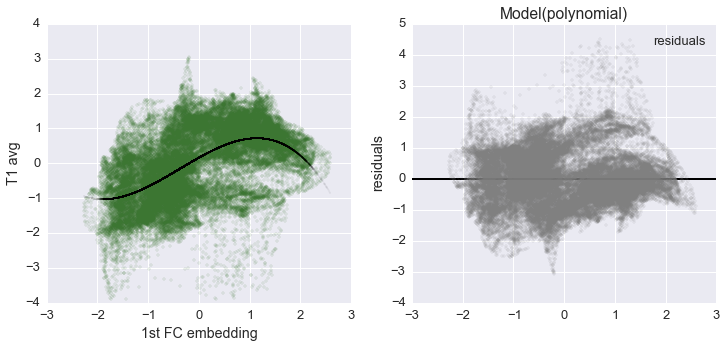

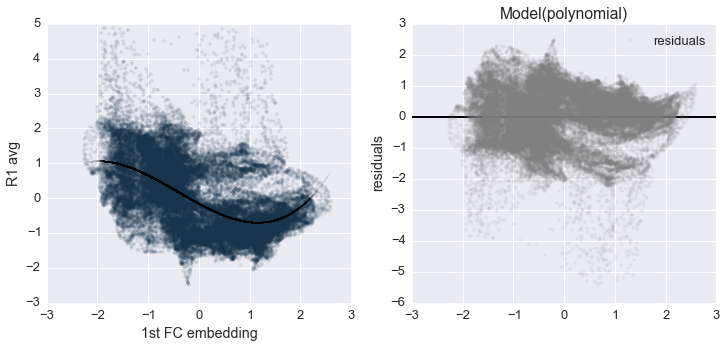

In [24]:
poly3_model = lmfit.models.PolynomialModel(degree=3)

poly3_pars_t1 = poly3_model.guess(t1_norm, x=embed1_t1_norm)
poly3_out_t1 = poly3_model.fit(t1_norm, poly3_pars_t1, x=embed1_t1_norm)
poly3_pars_r1 = poly3_model.guess(r1_norm, x=embed1_r1_norm)
poly3_out_r1 = poly3_model.fit(r1_norm, poly3_pars_r1, x=embed1_r1_norm)

custom_report(poly3_out_t1, 'T1')
custom_report(poly3_out_r1, 'R1')

custom_plot(embed1_t1_norm, t1_norm, poly3_out_t1, xlabel='1st FC embedding', ylabel='T1 avg', data_color=colors[3])
custom_plot(embed1_r1_norm, r1_norm, poly3_out_r1, xlabel='1st FC embedding', ylabel='R1 avg', data_color=colors[1])

### Polynomial fit degree=4

##### T1 #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 8
    # data points      = 58921
    # variables        = 5
    chi-square         = 39113.269
    reduced chi-square = 0.664
[[Variables]]
    c0:   0.19265402 +/- 0.005787 (3.00%) (init= 0.192654)
    c1:   0.83610399 +/- 0.007181 (0.86%) (init= 0.836104)
    c2:  -0.22087689 +/- 0.009086 (4.11%) (init=-0.2208769)
    c3:  -0.13900560 +/- 0.003244 (2.33%) (init=-0.1390056)
    c4:   0.02477572 +/- 0.002601 (10.50%) (init= 0.02477572)
[[Correlations]] (unreported correlations are <  0.100)
    C(c2, c4)                    = -0.928 
    C(c1, c3)                    = -0.879 
    C(c0, c2)                    = -0.748 
    C(c0, c4)                    =  0.577 
    C(c3, c4)                    = -0.443 
    C(c2, c3)                    =  0.345 
    C(c1, c4)                    =  0.336 
    C(c1, c2)                    = -0.280 
    C(c0, c3)                    = -0.226 
    C(c0, c1)             

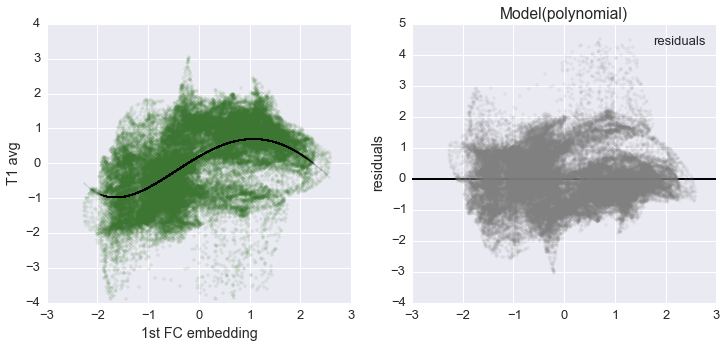

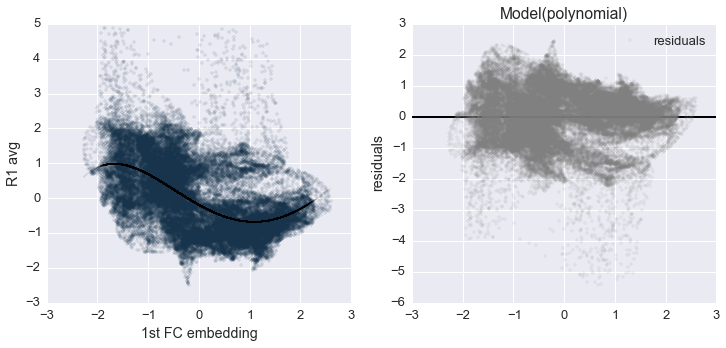

In [28]:
poly4_model = lmfit.models.PolynomialModel(degree=4)

poly4_pars_t1 = poly4_model.guess(t1_norm, x=embed1_t1_norm)
poly4_out_t1 = poly4_model.fit(t1_norm, poly4_pars_t1, x=embed1_t1_norm)
poly4_pars_r1 = poly4_model.guess(r1_norm, x=embed1_r1_norm)
poly4_out_r1 = poly4_model.fit(r1_norm, poly4_pars_r1, x=embed1_r1_norm)

custom_report(poly4_out_t1, 'T1')
custom_report(poly4_out_r1, 'R1')

custom_plot(embed1_t1_norm, t1_norm, poly4_out_t1, xlabel='1st FC embedding', ylabel='T1 avg', data_color=colors[3])
custom_plot(embed1_r1_norm, r1_norm, poly4_out_r1, xlabel='1st FC embedding', ylabel='R1 avg', data_color=colors[1])

### Polynomial fit degree=5

##### T1 #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 9
    # data points      = 58921
    # variables        = 6
    chi-square         = 38986.399
    reduced chi-square = 0.662
[[Variables]]
    c0:   0.18466545 +/- 0.005807 (3.14%) (init= 0.1846655)
    c1:   0.94168339 +/- 0.010466 (1.11%) (init= 0.9416834)
    c2:  -0.17169048 +/- 0.009742 (5.67%) (init=-0.1716905)
    c3:  -0.26628895 +/- 0.009746 (3.66%) (init=-0.266289)
    c4:   0.00446892 +/- 0.002982 (66.75%) (init= 0.004468929)
    c5:   0.02887874 +/- 0.002085 (7.22%) (init= 0.02887874)
[[Correlations]] (unreported correlations are <  0.100)
    C(c3, c5)                    = -0.943 
    C(c2, c4)                    = -0.932 
    C(c1, c3)                    = -0.887 
    C(c0, c2)                    = -0.729 
    C(c1, c5)                    =  0.729 
    C(c0, c4)                    =  0.549 
    C(c4, c5)                    = -0.492 
    C(c2, c5)                    =  0.365 
    C(

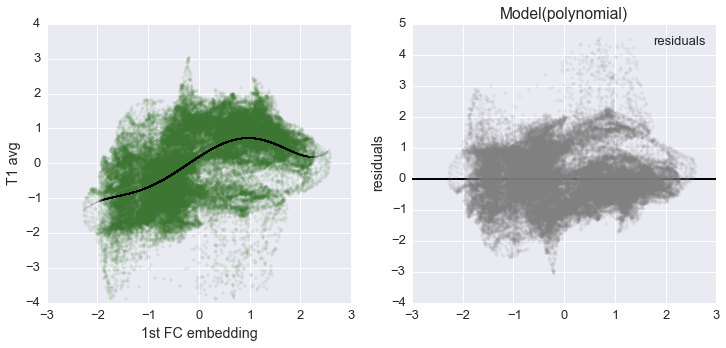

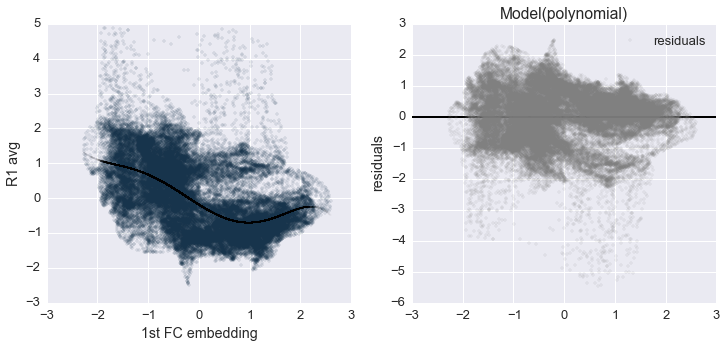

In [29]:
poly5_model = lmfit.models.PolynomialModel(degree=5)

poly5_pars_t1 = poly5_model.guess(t1_norm, x=embed1_t1_norm)
poly5_out_t1 = poly5_model.fit(t1_norm, poly5_pars_t1, x=embed1_t1_norm)
poly5_pars_r1 = poly5_model.guess(r1_norm, x=embed1_r1_norm)
poly5_out_r1 = poly5_model.fit(r1_norm, poly5_pars_r1, x=embed1_r1_norm)

custom_report(poly5_out_t1, 'T1')
custom_report(poly5_out_r1, 'R1')

custom_plot(embed1_t1_norm, t1_norm, poly5_out_t1, xlabel='1st FC embedding', ylabel='T1 avg', data_color=colors[3])
custom_plot(embed1_r1_norm, r1_norm, poly5_out_r1, xlabel='1st FC embedding', ylabel='R1 avg', data_color=colors[1])

### Polynomial fit degree=6

##### T1 #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 10
    # data points      = 58921
    # variables        = 7
    chi-square         = 38872.081
    reduced chi-square = 0.660
[[Variables]]
    c0:   0.22851219 +/- 0.006687 (2.93%) (init= 0.2285122)
    c1:   0.99282920 +/- 0.011150 (1.12%) (init= 0.9928292)
    c2:  -0.36123068 +/- 0.017377 (4.81%) (init=-0.3612307)
    c3:  -0.33896364 +/- 0.011189 (3.30%) (init=-0.3389636)
    c4:   0.13614694 +/- 0.010437 (7.67%) (init= 0.1361469)
    c5:   0.04812334 +/- 0.002544 (5.29%) (init= 0.04812335)
    c6:  -0.02250268 +/- 0.001709 (7.60%) (init=-0.02250268)
[[Correlations]] (unreported correlations are <  0.100)
    C(c4, c6)                    = -0.958 
    C(c3, c5)                    = -0.955 
    C(c2, c4)                    = -0.943 
    C(c1, c3)                    = -0.895 
    C(c2, c6)                    =  0.829 
    C(c0, c2)                    = -0.767 
    C(c1, c5)                   

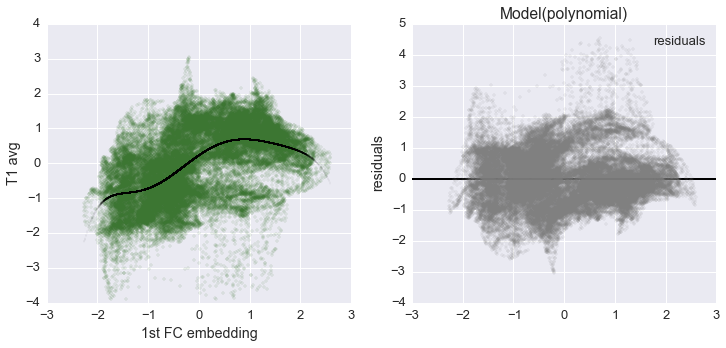

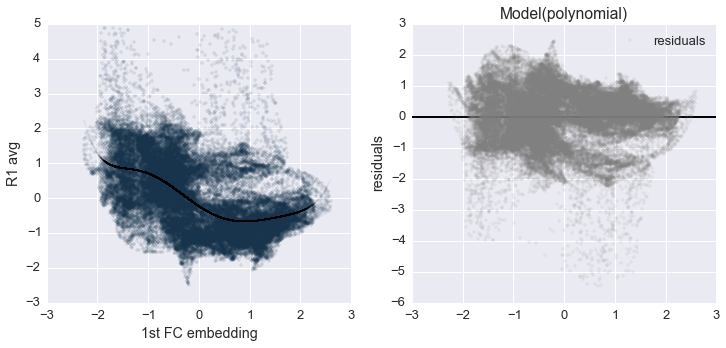

In [30]:
poly6_model = lmfit.models.PolynomialModel(degree=6)

poly6_pars_t1 = poly6_model.guess(t1_norm, x=embed1_t1_norm)
poly6_out_t1 = poly6_model.fit(t1_norm, poly6_pars_t1, x=embed1_t1_norm)
poly6_pars_r1 = poly6_model.guess(r1_norm, x=embed1_r1_norm)
poly6_out_r1 = poly6_model.fit(r1_norm, poly6_pars_r1, x=embed1_r1_norm)

custom_report(poly6_out_t1, 'T1')
custom_report(poly6_out_r1, 'R1')

custom_plot(embed1_t1_norm, t1_norm, poly6_out_t1, xlabel='1st FC embedding', ylabel='T1 avg', data_color=colors[3])
custom_plot(embed1_r1_norm, r1_norm, poly6_out_r1, xlabel='1st FC embedding', ylabel='R1 avg', data_color=colors[1])

### Polynomial fit degree=7

##### T1 #####
[[Model]]
    Model(polynomial)
[[Fit Statistics]]
    # function evals   = 11
    # data points      = 58921
    # variables        = 8
    chi-square         = 38868.234
    reduced chi-square = 0.660
[[Variables]]
    c0:   0.23082200 +/- 0.006755 (2.93%) (init= 0.230822)
    c1:   0.97055105 +/- 0.014471 (1.49%) (init= 0.9705511)
    c2:  -0.38083792 +/- 0.019180 (5.04%) (init=-0.3808379)
    c3:  -0.29304285 +/- 0.022063 (7.53%) (init=-0.2930429)
    c4:   0.15275179 +/- 0.012498 (8.18%) (init= 0.1527518)
    c5:   0.02523653 +/- 0.009813 (38.88%) (init= 0.02523653)
    c6:  -0.02573772 +/- 0.002171 (8.44%) (init=-0.02573772)
    c7:   0.00318001 +/- 0.001316 (41.41%) (init= 0.003180018)
[[Correlations]] (unreported correlations are <  0.100)
    C(c4, c6)                    = -0.969 
    C(c5, c7)                    = -0.966 
    C(c3, c5)                    = -0.958 
    C(c2, c4)                    = -0.946 
    C(c1, c3)                    = -0.899 
    C(c3, c7

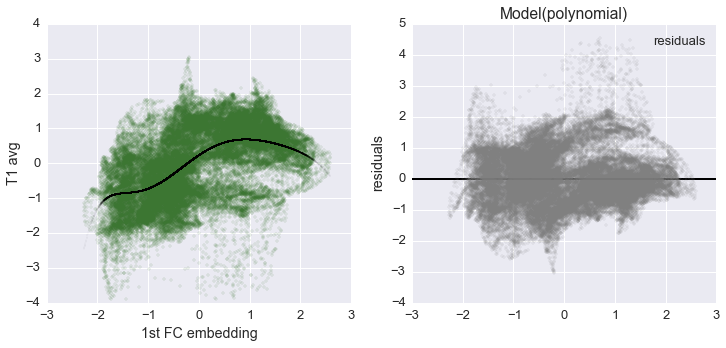

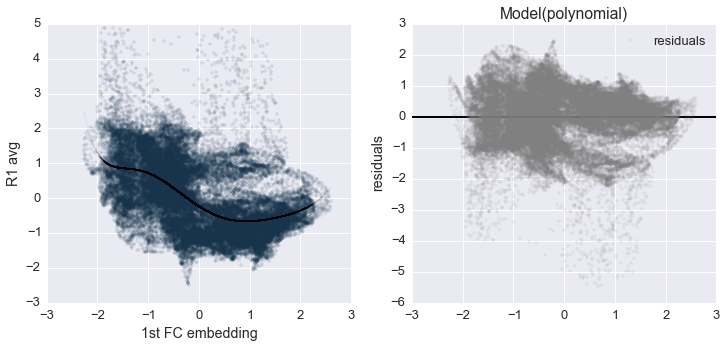

In [31]:
poly7_model = lmfit.models.PolynomialModel(degree=7)

poly7_pars_t1 = poly7_model.guess(t1_norm, x=embed1_t1_norm)
poly7_out_t1 = poly7_model.fit(t1_norm, poly7_pars_t1, x=embed1_t1_norm)
poly7_pars_r1 = poly7_model.guess(r1_norm, x=embed1_r1_norm)
poly7_out_r1 = poly7_model.fit(r1_norm, poly7_pars_r1, x=embed1_r1_norm)

custom_report(poly7_out_t1, 'T1')
custom_report(poly7_out_r1, 'R1')

custom_plot(embed1_t1_norm, t1_norm, poly7_out_t1, xlabel='1st FC embedding', ylabel='T1 avg', data_color=colors[3])
custom_plot(embed1_r1_norm, r1_norm, poly7_out_r1, xlabel='1st FC embedding', ylabel='R1 avg', data_color=colors[1])

### Linear step function

##### T1 #####
[[Model]]
    Model(step, form='linear')
[[Fit Statistics]]
    # function evals   = 44
    # data points      = 58921
    # variables        = 3
    chi-square         = 50133.999
    reduced chi-square = 0.851
[[Variables]]
    amplitude:   0.59075413 +/- 0.006199 (1.05%) (init= 6.952592)
    sigma:       0.75030933 +/- 0.037796 (5.04%) (init= 0.694249)
    center:     -0.36257669 +/- 0.018798 (5.18%) (init= 0.1643948)
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, center)             = -0.800 
    C(amplitude, sigma)          =  0.208 

BIC -9479.68188131
AIC -9506.63373984

##### R1 #####
[[Model]]
    Model(step, form='linear')
[[Fit Statistics]]
    # function evals   = 66
    # data points      = 58818
    # variables        = 3
    chi-square         = 50343.275
    reduced chi-square = 0.856
[[Variables]]
    amplitude:  -0.58238936 +/- 0.006254 (1.07%) (init= 7.360541)
    sigma:       0.77376153 +/- 0.039101 (5.05%) (init= 0.6951065)
    

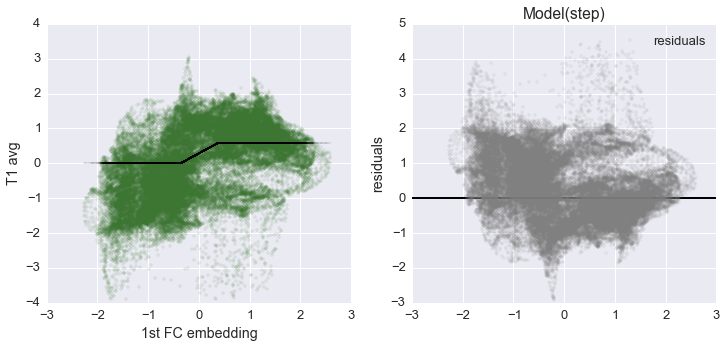

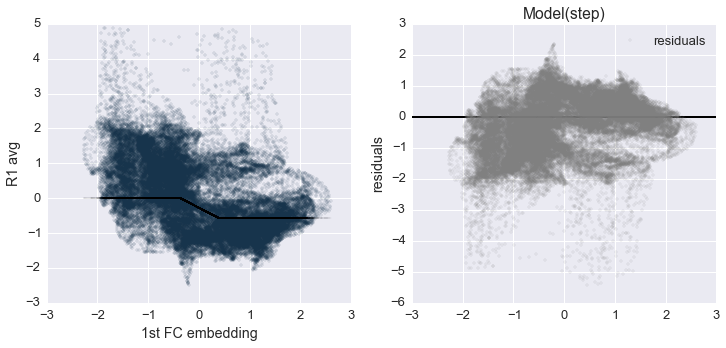

In [47]:
steplin_model = lmfit.models.StepModel(form='linear')

steplin_pars_t1 = steplin_model.guess(t1_norm, x=embed1_t1_norm)
steplin_out_t1 = steplin_model.fit(t1_norm, steplin_pars_t1, x=embed1_t1_norm)
steplin_pars_r1 = steplin_model.guess(r1_norm, x=embed1_r1_norm)
steplin_out_r1 = steplin_model.fit(r1_norm, steplin_pars_r1, x=embed1_r1_norm)

custom_report(steplin_out_t1, 'T1')
custom_report(steplin_out_r1, 'R1')

custom_plot(embed1_t1_norm, t1_norm, steplin_out_t1, xlabel='1st FC embedding', ylabel='T1 avg', data_color=colors[3])
custom_plot(embed1_r1_norm, r1_norm, steplin_out_r1, xlabel='1st FC embedding', ylabel='R1 avg', data_color=colors[1])

### Arctan step model

##### T1 #####
[[Model]]
    Model(step, form='arctan')
[[Fit Statistics]]
    # function evals   = 317
    # data points      = 58921
    # variables        = 3
    chi-square         = 50388.159
    reduced chi-square = 0.855
[[Variables]]
    amplitude:   0.55215243 +/- 0.005635 (1.02%) (init= 6.952592)
    sigma:       0.00384010 +/- 0.002024 (52.71%) (init= 0.694249)
    center:     -0.09832416 +/- 0.001908 (1.94%) (init= 0.1643948)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, sigma)          =  0.186 

BIC -9181.72866321
AIC -9208.68052174

##### R1 #####
[[Model]]
    Model(step, form='arctan')
[[Fit Statistics]]
    # function evals   = 269
    # data points      = 58818
    # variables        = 3
    chi-square         = 50598.779
    reduced chi-square = 0.860
[[Variables]]
    amplitude:  -0.54230059 +/- 0.005666 (1.04%) (init= 7.360541)
    sigma:       0.00415345 +/- 0.002155 (51.89%) (init= 0.6951065)
    center:     -0.10047717 +/- 0.002080 (2

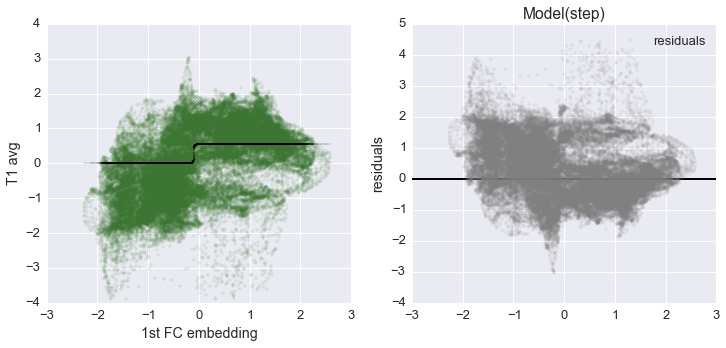

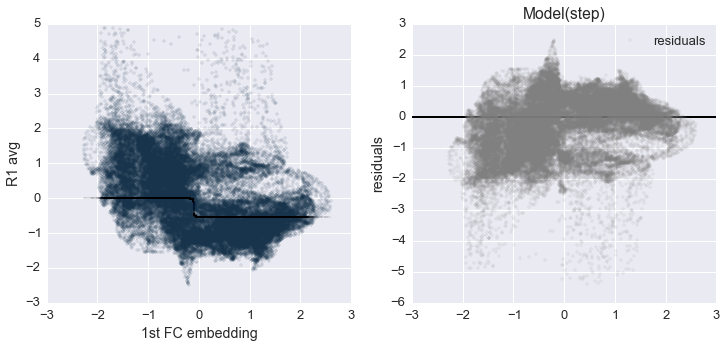

In [36]:
stepatan_model = lmfit.models.StepModel(form='arctan')

stepatan_pars_t1 = stepatan_model.guess(t1_norm, x=embed1_t1_norm)
stepatan_out_t1 = stepatan_model.fit(t1_norm, stepatan_pars_t1, x=embed1_t1_norm)
stepatan_pars_r1 = stepatan_model.guess(r1_norm, x=embed1_r1_norm)
stepatan_out_r1 = stepatan_model.fit(r1_norm, stepatan_pars_r1, x=embed1_r1_norm)

custom_report(stepatan_out_t1, 'T1')
custom_report(stepatan_out_r1, 'R1')

custom_plot(embed1_t1_norm, t1_norm, stepatan_out_t1, xlabel='1st FC embedding', ylabel='T1 avg', data_color=colors[3])
custom_plot(embed1_r1_norm, r1_norm, stepatan_out_r1, xlabel='1st FC embedding', ylabel='R1 avg', data_color=colors[1])

##### T1 #####
[[Model]]
    Model(step, form='logistic')
[[Fit Statistics]]
    # function evals   = 54
    # data points      = 58921
    # variables        = 3
    chi-square         = 50190.411
    reduced chi-square = 0.852
[[Variables]]
    amplitude:   0.56815520 +/- 0.005879 (1.03%) (init= 6.952592)
    sigma:       0.07300738 +/- 0.007467 (10.23%) (init= 0.694249)
    center:     -0.08878275 +/- 0.008653 (9.75%) (init= 0.1643948)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, center)         =  0.258 
    C(amplitude, sigma)          =  0.191 
    C(sigma, center)             =  0.170 

BIC -9413.41891586
AIC -9440.37077439

##### R1 #####
[[Model]]
    Model(step, form='logistic')
[[Fit Statistics]]
    # function evals   = 164
    # data points      = 58818
    # variables        = 3
    chi-square         = 50405.223
    reduced chi-square = 0.857
[[Variables]]
    amplitude:  -0.55905026 +/- 0.005919 (1.06%) (init= 7.360541)
    sigma:       0.075

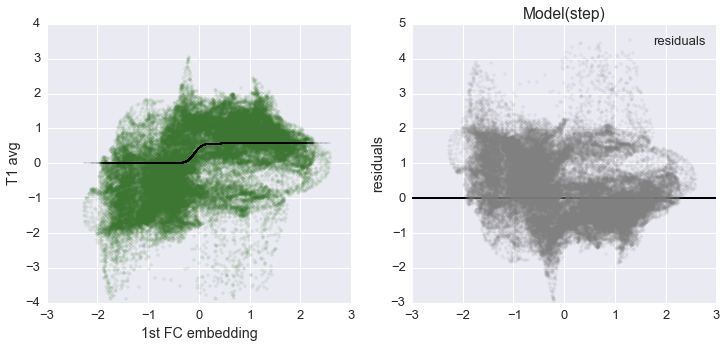

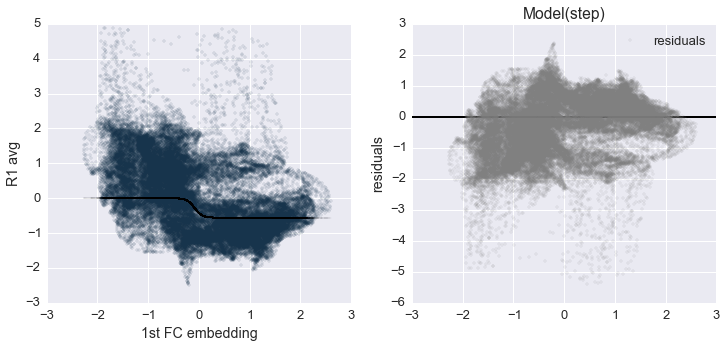

In [37]:
steplog_model = lmfit.models.StepModel(form='logistic')

steplog_pars_t1 = steplog_model.guess(t1_norm, x=embed1_t1_norm)
steplog_out_t1 = steplog_model.fit(t1_norm, steplog_pars_t1, x=embed1_t1_norm)
steplog_pars_r1 = steplog_model.guess(r1_norm, x=embed1_r1_norm)
steplog_out_r1 = steplog_model.fit(r1_norm, steplog_pars_r1, x=embed1_r1_norm)

custom_report(steplog_out_t1, 'T1')
custom_report(steplog_out_r1, 'R1')

custom_plot(embed1_t1_norm, t1_norm, steplog_out_t1, xlabel='1st FC embedding', ylabel='T1 avg', data_color=colors[3])
custom_plot(embed1_r1_norm, r1_norm, steplog_out_r1, xlabel='1st FC embedding', ylabel='R1 avg', data_color=colors[1])

### Noisy step function

##### T1 #####
[[Model]]
    Model(step, form='erf')
[[Fit Statistics]]
    # function evals   = 73
    # data points      = 58921
    # variables        = 3
    chi-square         = 50171.063
    reduced chi-square = 0.852
[[Variables]]
    amplitude:   0.57065902 +/- 0.005909 (1.04%) (init= 6.952592)
    sigma:       0.19577794 +/- 0.017981 (9.18%) (init= 0.694249)
    center:     -0.08077029 +/- 0.009253 (11.46%) (init= 0.1643948)
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, center)         =  0.271 
    C(sigma, center)             =  0.197 
    C(amplitude, sigma)          =  0.187 

BIC -9436.13716118
AIC -9463.08901971

##### R1 #####
[[Model]]
    Model(step, form='erf')
[[Fit Statistics]]
    # function evals   = 88
    # data points      = 58818
    # variables        = 3
    chi-square         = 50386.620
    reduced chi-square = 0.857
[[Variables]]
    amplitude:  -0.56164692 +/- 0.005950 (1.06%) (init= 7.360541)
    sigma:       0.20280639 +/- 0

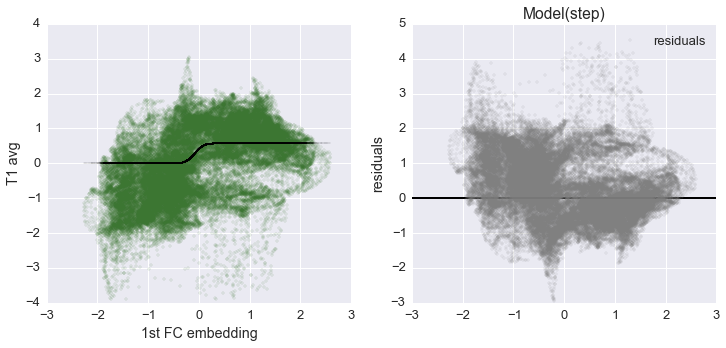

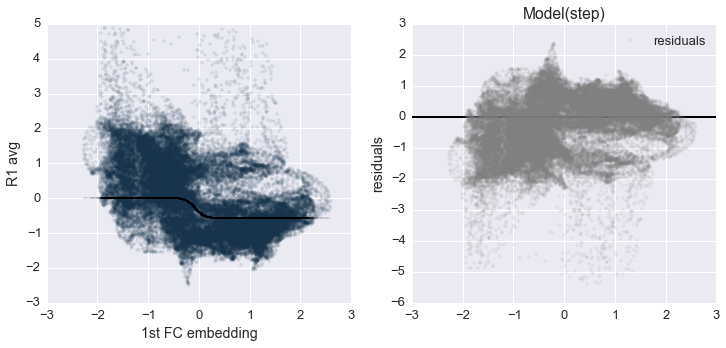

In [39]:
steperr_model = lmfit.models.StepModel(form='erf')

steperr_pars_t1 = steperr_model.guess(t1_norm, x=embed1_t1_norm)
steperr_out_t1 = steperr_model.fit(t1_norm, steperr_pars_t1, x=embed1_t1_norm)
steperr_pars_r1 = steperr_model.guess(r1_norm, x=embed1_r1_norm)
steperr_out_r1 = steperr_model.fit(r1_norm, steperr_pars_r1, x=embed1_r1_norm)

custom_report(steperr_out_t1, 'T1')
custom_report(steperr_out_r1, 'R1')

custom_plot(embed1_t1_norm, t1_norm, steperr_out_t1, xlabel='1st FC embedding', ylabel='T1 avg', data_color=colors[3])
custom_plot(embed1_r1_norm, r1_norm, steperr_out_r1, xlabel='1st FC embedding', ylabel='R1 avg', data_color=colors[1])

### Linear step function with constant

##### T1 #####
[[Model]]
    (Model(step, prefix='step_', form='linear') + Model(linear, prefix='const_'))
[[Fit Statistics]]
    # function evals   = 113
    # data points      = 58921
    # variables        = 4
    chi-square         = 39230.508
    reduced chi-square = 0.666
[[Variables]]
    const_slope:       0 (fixed)
    const_intercept:  -0.79280821 +/- 0.007058 (0.89%) (init=-3.892915)
    step_amplitude:    1.36587456 +/- 0.008763 (0.64%) (init= 6.952592)
    step_sigma:        0.99756043 +/- 0.017258 (1.73%) (init= 0.694249)
    step_center:      -0.83811292 +/- 0.009851 (1.18%) (init= 0.1643948)
[[Correlations]] (unreported correlations are <  0.100)
    C(step_sigma, step_center)   = -0.845 
    C(const_intercept, step_amplitude)  = -0.805 
    C(const_intercept, step_center)  =  0.523 
    C(step_amplitude, step_center)  = -0.422 
    C(step_amplitude, step_sigma)  =  0.371 
    C(const_intercept, step_sigma)  = -0.299 

BIC -23917.7603861
AIC -23953.6961975

##### R1 ###

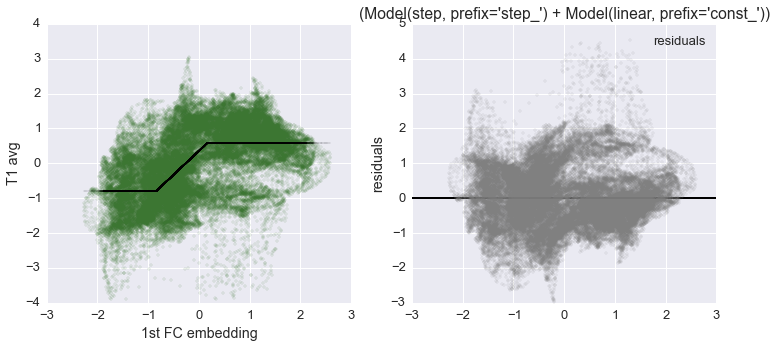

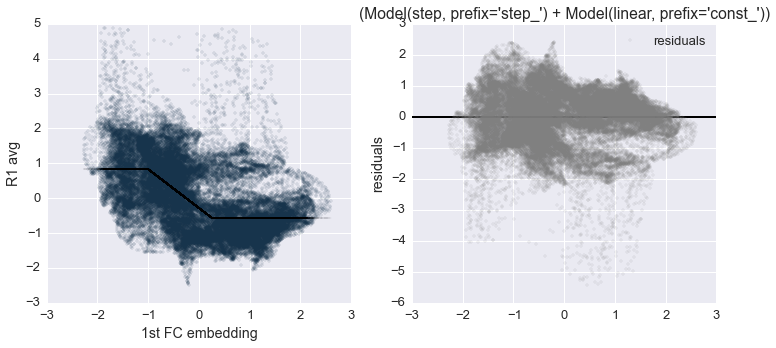

In [57]:
steplin_model = lmfit.models.StepModel(form='linear', prefix='step_')
const_model = lmfit.models.LinearModel(prefix='const_')
const_model.set_param_hint(name='slope', value=0, vary=False)
steplin_const_model = steplin_model + const_model

steplin_const_pars_t1 = const_model.make_params(intercept=t1_norm.min())
steplin_const_pars_t1 += steplin_model.guess(t1_norm, x=embed1_t1_norm)
steplin_const_out_t1 = steplin_const_model.fit(t1_norm, steplin_const_pars_t1, x=embed1_t1_norm)
steplin_const_pars_r1 = const_model.make_params(intercept=r1_norm.max())
steplin_const_pars_r1 += steplin_model.guess(r1_norm, x=embed1_r1_norm)
steplin_const_out_r1 = steplin_const_model.fit(r1_norm, steplin_const_pars_r1, x=embed1_r1_norm)

custom_report(steplin_const_out_t1, 'T1')
custom_report(steplin_const_out_r1, 'R1')

custom_plot(embed1_t1_norm, t1_norm, steplin_const_out_t1, xlabel='1st FC embedding', ylabel='T1 avg', data_color=colors[3])
custom_plot(embed1_r1_norm, r1_norm, steplin_const_out_r1, xlabel='1st FC embedding', ylabel='R1 avg', data_color=colors[1])

### Arctan step function + constant

##### T1 #####
[[Model]]
    (Model(step, prefix='step_', form='erf') + Model(linear, prefix='const_'))
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 58921
    # variables        = 4
    chi-square         = 39060.231
    reduced chi-square = 0.663
[[Variables]]
    const_slope:       0 (fixed)
    const_intercept:  -0.83197189 +/- 0.008577 (1.03%) (init=-3.892915)
    step_amplitude:    1.42260265 +/- 0.010649 (0.75%) (init= 6.952592)
    step_sigma:        0.53260883 +/- 0.012740 (2.39%) (init= 0.694249)
    step_center:      -0.34436974 +/- 0.006097 (1.77%) (init= 0.1643948)
[[Correlations]] (unreported correlations are <  0.100)
    C(const_intercept, step_amplitude)  = -0.855 
    C(step_amplitude, step_sigma)  =  0.599 
    C(const_intercept, step_center)  =  0.549 
    C(const_intercept, step_sigma)  = -0.525 
    C(step_amplitude, step_center)  = -0.261 

BIC -24174.0577794
AIC -24209.9935907

##### R1 #####
[[Model]]
    (Model(step, prefix='step_', f

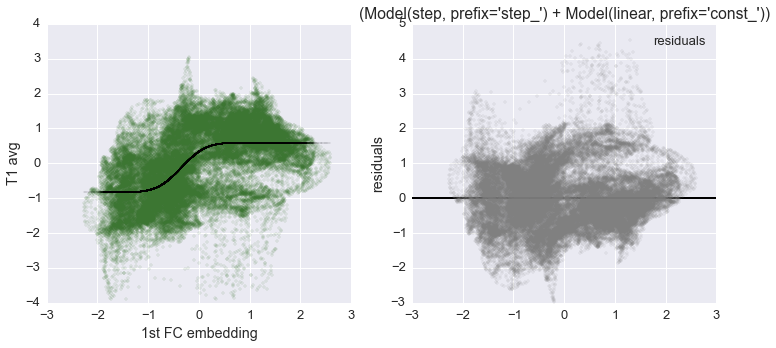

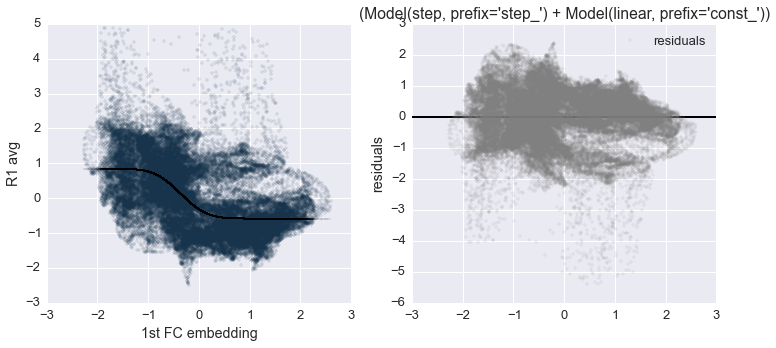

In [58]:
stepatan_model = lmfit.models.StepModel(form='atan', prefix='step_')
const_model = lmfit.models.LinearModel(prefix='const_')
const_model.set_param_hint(name='slope', value=0, vary=False)
stepatan_const_model = stepatan_model + const_model

steperr_const_pars_t1 = const_model.make_params(intercept=t1_norm.min())
steperr_const_pars_t1 += steperr_model.guess(t1_norm, x=embed1_t1_norm)
steperr_const_out_t1 = steperr_const_model.fit(t1_norm, steperr_const_pars_t1, x=embed1_t1_norm)
steperr_const_pars_r1 = const_model.make_params(intercept=r1_norm.max())
steperr_const_pars_r1 += steperr_model.guess(r1_norm, x=embed1_r1_norm)
steperr_const_out_r1 = steperr_const_model.fit(r1_norm, steperr_const_pars_r1, x=embed1_r1_norm)

custom_report(steperr_const_out_t1, 'T1')
custom_report(steperr_const_out_r1, 'R1')

custom_plot(embed1_t1_norm, t1_norm, steperr_const_out_t1, xlabel='1st FC embedding', ylabel='T1 avg', data_color=colors[3])
custom_plot(embed1_r1_norm, r1_norm, steperr_const_out_r1, xlabel='1st FC embedding', ylabel='R1 avg', data_color=colors[1])

### Logistic step function + constant

##### T1 #####
[[Model]]
    (Model(step, prefix='step_', form='logistic') + Model(linear, prefix='const_'))
[[Fit Statistics]]
    # function evals   = 33
    # data points      = 58921
    # variables        = 4
    chi-square         = 42338.589
    reduced chi-square = 0.719
[[Variables]]
    const_slope:       0 (fixed)
    const_intercept:  -0.51743863 +/- 0        (0.00%) (init=-3.892915)
    step_amplitude:    1.06133821 +/- 0        (0.00%) (init= 6.952592)
    step_sigma:        5.5096e-07 +/- 0        (0.00%) (init= 0.694249)
    step_center:      -0.12676883 +/- 0        (0.00%) (init= 0.1643948)
[[Correlations]] (unreported correlations are <  0.100)

BIC -19425.3738758
AIC -19461.3096872

##### R1 #####
[[Model]]
    (Model(step, prefix='step_', form='logistic') + Model(linear, prefix='const_'))
[[Fit Statistics]]
    # function evals   = 76
    # data points      = 58818
    # variables        = 4
    chi-square         = 39497.303
    reduced chi-square = 0.672
[[Variab

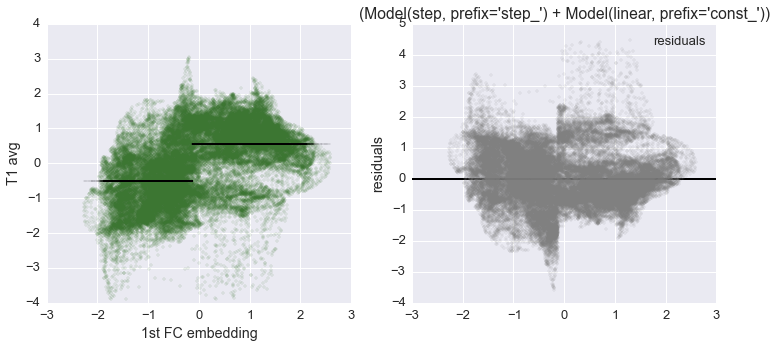

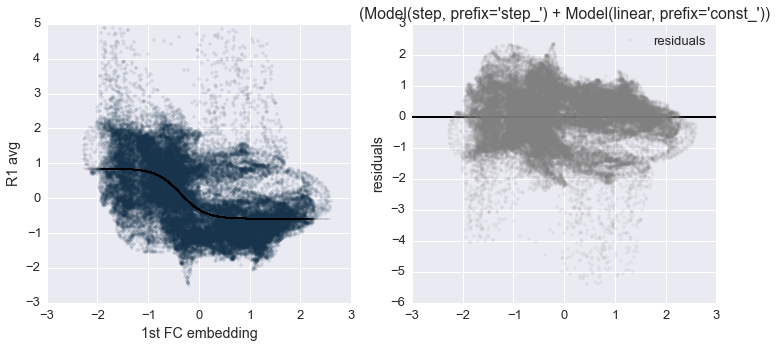

In [64]:
steplog_model = lmfit.models.StepModel(form='logistic', prefix='step_')
const_model = lmfit.models.LinearModel(prefix='const_')
const_model.set_param_hint(name='slope', value=0, vary=False)
steplog_const_model = steplog_model + const_model

steplog_const_pars_t1 = const_model.make_params(intercept=t1_norm.min())
steplog_const_pars_t1 += steplog_model.guess(t1_norm, x=embed1_t1_norm)
steplog_const_out_t1 = steplog_const_model.fit(t1_norm, steplog_const_pars_t1, x=embed1_t1_norm)
steplog_const_pars_r1 = const_model.make_params(intercept=r1_norm.max())
steplog_const_pars_r1 += steplog_model.guess(r1_norm, x=embed1_r1_norm)
steplog_const_out_r1 = steplog_const_model.fit(r1_norm, steplog_const_pars_r1, x=embed1_r1_norm)

custom_report(steplog_const_out_t1, 'T1')
custom_report(steplog_const_out_r1, 'R1')

custom_plot(embed1_t1_norm, t1_norm, steplog_const_out_t1, xlabel='1st FC embedding', ylabel='T1 avg', data_color=colors[3])
custom_plot(embed1_r1_norm, r1_norm, steplog_const_out_r1, xlabel='1st FC embedding', ylabel='R1 avg', data_color=colors[1])

### Noisy step function + constant

##### T1 #####
[[Model]]
    (Model(step, prefix='step_', form='erf') + Model(linear, prefix='const_'))
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 58921
    # variables        = 4
    chi-square         = 39060.231
    reduced chi-square = 0.663
[[Variables]]
    const_slope:       0 (fixed)
    const_intercept:  -0.83197189 +/- 0.008577 (1.03%) (init=-3.892915)
    step_amplitude:    1.42260265 +/- 0.010649 (0.75%) (init= 6.952592)
    step_sigma:        0.53260883 +/- 0.012740 (2.39%) (init= 0.694249)
    step_center:      -0.34436974 +/- 0.006097 (1.77%) (init= 0.1643948)
[[Correlations]] (unreported correlations are <  0.100)
    C(const_intercept, step_amplitude)  = -0.855 
    C(step_amplitude, step_sigma)  =  0.599 
    C(const_intercept, step_center)  =  0.549 
    C(const_intercept, step_sigma)  = -0.525 
    C(step_amplitude, step_center)  = -0.261 

BIC -24174.0577794
AIC -24209.9935907

##### R1 #####
[[Model]]
    (Model(step, prefix='step_', f

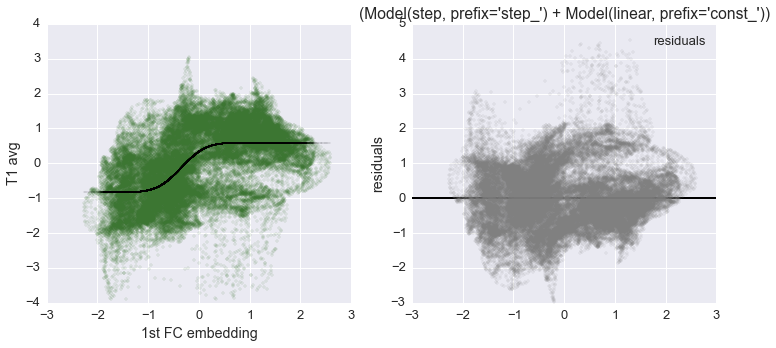

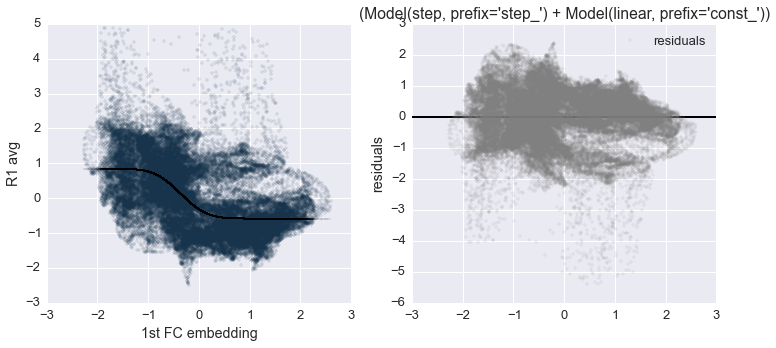

In [59]:
steperr_model = lmfit.models.StepModel(form='erf', prefix='step_')
const_model = lmfit.models.LinearModel(prefix='const_')
const_model.set_param_hint(name='slope', value=0, vary=False)
steperr_const_model = steperr_model + const_model

steperr_const_pars_t1 = const_model.make_params(intercept=t1_norm.min())
steperr_const_pars_t1 += steperr_model.guess(t1_norm, x=embed1_t1_norm)
steperr_const_out_t1 = steperr_const_model.fit(t1_norm, steperr_const_pars_t1, x=embed1_t1_norm)
steperr_const_pars_r1 = const_model.make_params(intercept=r1_norm.max())
steperr_const_pars_r1 += steperr_model.guess(r1_norm, x=embed1_r1_norm)
steperr_const_out_r1 = steperr_const_model.fit(r1_norm, steperr_const_pars_r1, x=embed1_r1_norm)

custom_report(steperr_const_out_t1, 'T1')
custom_report(steperr_const_out_r1, 'R1')

custom_plot(embed1_t1_norm, t1_norm, steperr_const_out_t1, xlabel='1st FC embedding', ylabel='T1 avg', data_color=colors[3])
custom_plot(embed1_r1_norm, r1_norm, steperr_const_out_r1, xlabel='1st FC embedding', ylabel='R1 avg', data_color=colors[1])

### Step function convolved with Gaussian

In [ ]:
def convolve(arr, kernel):
    # simple convolution of two arrays
    npts = min(len(arr), len(kernel))
    pad  = np.ones(npts)
    tmp  = np.concatenate((pad*arr[0], arr, pad*arr[-1]))
    out  = np.convolve(tmp, kernel, mode='valid')
    noff = int((len(out) - npts)/2)
    return out[noff:noff+npts]

# create Composite Model using the custom convolution operator
mod  = CompositeModel(Model(jump), Model(gaussian), convolve)

pars = mod.make_params(amplitude=1, center=3.5, sigma=1.5, mid=5.0)

# 'mid' and 'center' should be completely correlated, and 'mid' is
# used as an integer index, so a very poor fit variable:
pars['mid'].vary = False

# fit this model to data array y
result =  mod.fit(y, params=pars, x=x)

print(result.fit_report())

plot_components = False

# plot results
plt.plot(x, y,         'bo')
if plot_components:
    # generate components
    comps = result.eval_components(x=x)
    plt.plot(x, 10*comps['jump'], 'k--')
    plt.plot(x, 10*comps['gaussian'], 'r-')
else:
    plt.plot(x, result.init_fit, 'k--')
    plt.plot(x, result.best_fit, 'r-')
plt.show()